In [83]:
# data wrangling and linear algebra
import pandas as pd
import numpy as np
import pandas_ta as ta

# data visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib

# metrics
from sklearn import metrics
from sklearn import preprocessing

# yahoo finance api
import yfinance as yf

# statistical tests
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# framework
import tensorflow as tf
from tensorflow.keras import layers, models

# misc
import warnings
import os


warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows',500)
matplotlib.rcParams['figure.figsize']  = (12,8)

In [2]:
# get netflix stock data
stock = yf.Ticker('NFLX')

In [3]:
# get historical market data
hist = stock.history(start = '2010-08-01', end = '2020-07-31', period = '1d')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-08-02,14.86,15.00,14.42,14.55,24295600,0,0.0
2010-08-03,14.44,14.96,14.10,14.92,30139200,0,0.0
2010-08-04,15.00,15.50,14.96,15.45,24243100,0,0.0
2010-08-05,15.32,15.81,15.07,15.79,24296300,0,0.0
2010-08-06,15.53,16.96,15.41,16.90,48693400,0,0.0
...,...,...,...,...,...,...,...
2020-07-24,468.77,487.17,467.54,480.45,7746200,0,0.0
2020-07-27,484.51,496.92,482.31,495.65,7863100,0,0.0
2020-07-28,496.02,497.79,487.76,488.51,5986700,0,0.0


In [4]:
# droppping stock splits and dividends
hist.drop(['Dividends', 'Stock Splits'], axis = 1, inplace=True)
hist.columns =  ['open', 'high', 'low', 'close', 'volume']

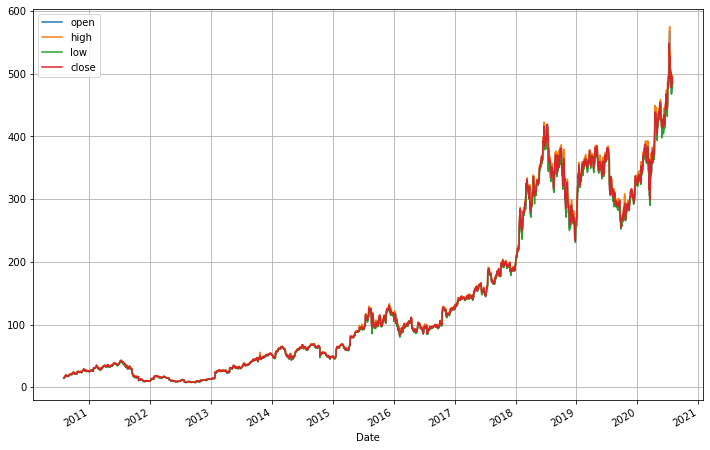

In [5]:
hist.drop('volume', axis = 1).plot(grid = True)
plt.show()

In [84]:
# scaler 
scaler = preprocessing.StandardScaler()

In [125]:
train_data

,open,high,low,close,volume
Date,,,,,
2010-08-02,14.86,15.00,14.42,14.55,24295600
2010-08-03,14.44,14.96,14.10,14.92,30139200
2010-08-04,15.00,15.50,14.96,15.45,24243100
2010-08-05,15.32,15.81,15.07,15.79,24296300
2010-08-06,15.53,16.96,15.41,16.90,48693400
...,...,...,...,...,...
2018-12-24,242.00,250.65,233.68,233.88,9547600
2018-12-26,233.92,254.50,231.23,253.67,14402700
2018-12-27,250.11,255.59,240.10,255.57,12235200


In [114]:
def create_dataset(data, window_size = 50):
    data = data.copy()
    x = []
    y = []
    closep = data['close'].values
    for time in range(len(data)-window_size):
        window_data = data.iloc[time:time+window_size-1,:]
        normalised_window = []
        for col in range(data.shape[1]):
            #norm_col = ((window_data.iloc[:,col]/window_data.iloc[0,col])-1).values
            norm_col = scaler.fit_transform(window_data.iloc[:,col].values.reshape(-1,1)).flatten()
            normalised_window.append(norm_col)
        normalised_window = np.array(normalised_window).T
        x.append(normalised_window)
        
        close_w = closep[time:time+window_size]
        prev_close = close_w[-2]
        next_close = close_w[-1]
        
        if next_close > prev_close:
            y.append([1,0])
        else:
            y.append([0,1])
           
    return np.array(x), np.array(y)

In [115]:
def split_data(df, split_time):
    split_index = len(hist.loc[hist.index < split_time])
    train_data = hist.iloc[:split_index]
    val_data = hist.iloc[split_index:]
    
    return split_index, train_data, val_data

split_index, train_data, val_data = split_data(hist, '2019-01-01')

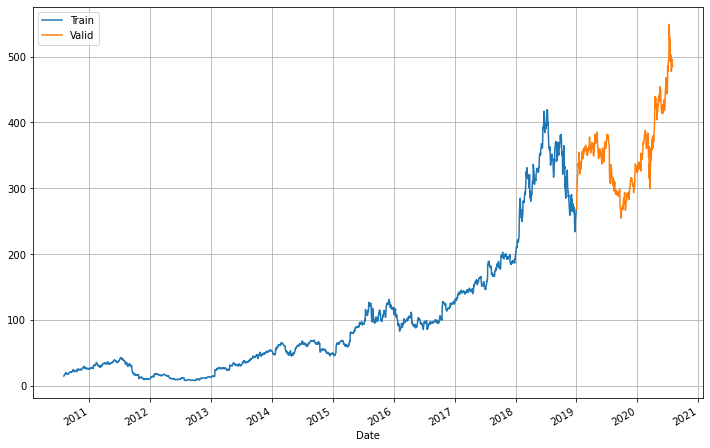

In [116]:
pd.concat([train_data['close'], val_data['close']], axis = 1).plot(grid = True)
plt.legend(['Train', 'Valid'])
plt.show()

In [146]:
# params
window_size = 31
batch_size = 32
epochs = 100
shuffle_buffer = 1000

In [147]:
X,Y = create_dataset(train_data, window_size = window_size)
print(X.shape, Y.shape)

(2088, 30, 5) (2088, 2)


Code Source: https://github.com/Rachnog/Deep-Trading/blob/master/multivariate/utils.py

In [148]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test


In [149]:
X_train, X_val, y_train, y_val = create_Xt_Yt(X, Y)

In [150]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1879, 30, 5) (209, 30, 5) (1879, 2) (209, 2)


In [154]:
tf.keras.backend.clear_session()

# model architecture

"""# create model
model = models.Sequential([
    layers.Conv1D(16, 4, input_shape = [X.shape[1], X.shape[-1]]),
    layers.LSTM(50, return_sequences = False),
    layers.Dropout(0.5),    
    layers.Dense(50, activation = 'relu'),           
    layers.Dense(2, activation = 'softmax')    
])"""

model = models.Sequential()
model.add(layers.Conv1D(16, 4, input_shape = [X.shape[1], X.shape[-1]], padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Conv1D(8, 4, input_shape = [X.shape[1], X.shape[-1]], padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))


model.add(layers.LSTM(50, return_sequences = False))

model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())


model.add(layers.Dense(2))
model.add(layers.Activation('softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)


model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 16)            336       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 16)            64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 8)             520       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 8)             32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 8)             0

In [155]:
history = model.fit(X_train, y_train, epochs = epochs, validation_data=(X_val, y_val)) 

Epoch 1/100
59/59 [==============================] - 1s 14ms/step - loss: 0.8052 - accuracy: 0.4859 - val_loss: 0.6945 - val_accuracy: 0.4593
Epoch 2/100
59/59 [==============================] - 0s 7ms/step - loss: 0.7414 - accuracy: 0.5056 - val_loss: 0.6948 - val_accuracy: 0.4306
Epoch 3/100
59/59 [==============================] - 0s 7ms/step - loss: 0.7248 - accuracy: 0.4875 - val_loss: 0.6952 - val_accuracy: 0.4737
Epoch 4/100
59/59 [==============================] - 0s 7ms/step - loss: 0.7085 - accuracy: 0.5109 - val_loss: 0.6945 - val_accuracy: 0.4833
Epoch 5/100
59/59 [==============================] - 0s 7ms/step - loss: 0.7159 - accuracy: 0.4955 - val_loss: 0.6948 - val_accuracy: 0.4880
Epoch 6/100
59/59 [==============================] - 0s 7ms/step - loss: 0.7083 - accuracy: 0.5258 - val_loss: 0.6967 - val_accuracy: 0.4928
Epoch 7/100
59/59 [==============================] - 0s 7ms/step - loss: 0.7127 - accuracy: 0.4976 - val_loss: 0.6952 - val_accuracy: 0.4737
Epoch 8/100


Epoch 59/100
59/59 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.5114 - val_loss: 0.6981 - val_accuracy: 0.4928
Epoch 60/100
59/59 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5263 - val_loss: 0.7004 - val_accuracy: 0.5120
Epoch 61/100
59/59 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.5370 - val_loss: 0.6990 - val_accuracy: 0.5024
Epoch 62/100
59/59 [==============================] - 0s 7ms/step - loss: 0.6992 - accuracy: 0.4987 - val_loss: 0.6955 - val_accuracy: 0.4833
Epoch 63/100
59/59 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.5184 - val_loss: 0.6944 - val_accuracy: 0.4737
Epoch 64/100
59/59 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5274 - val_loss: 0.6950 - val_accuracy: 0.5120
Epoch 65/100
59/59 [==============================] - 0s 7ms/step - loss: 0.6962 - accuracy: 0.5120 - val_loss: 0.6953 - val_accuracy: 0.5024
Epoch 

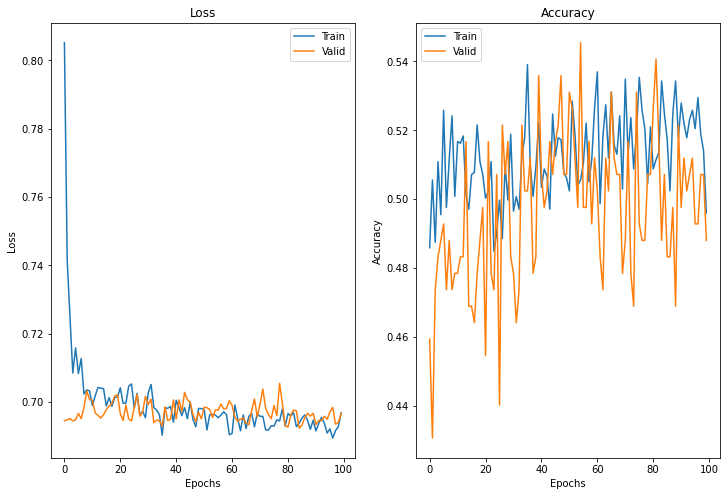

In [156]:
# plotting
plt.subplot(121)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Valid')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Valid')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()